# Tracing ttnn operations and torch modules/functions

In [1]:
import os
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

In [2]:
import torch
import transformers

import ttnn
from ttnn.tracer import trace, visualize

2024-07-11 18:17:47.183 | DEBUG    | ttnn:<module>:133 - Loading ttnn configuration overrides from environment variable TTNN_CONFIG_OVERRIDES
2024-07-11 18:17:47.184 | DEBUG    | ttnn:<module>:136 - Initial ttnn.CONFIG:
{'cache_path': PosixPath('/home/ubuntu/.cache/ttnn'),
 'comparison_mode_pcc': 0.9999,
 'enable_comparison_mode': False,
 'enable_detailed_buffer_report': False,
 'enable_detailed_tensor_report': False,
 'enable_fast_runtime_mode': False,
 'enable_graph_report': False,
 'enable_logging': False,
 'enable_model_cache': False,
 'model_cache_path': PosixPath('/home/ubuntu/.cache/ttnn/models'),
 'report_name': None,
 'root_report_path': PosixPath('generated/ttnn/reports'),
 'throw_exception_on_fallback': False,
 'tmp_dir': PosixPath('/tmp/ttnn')}
2024-07-11 18:17:47.354 | WARNING  | ttnn.decorators:operation_decorator:758 - Should ttnn.logical_xor be migrated to C++?
2024-07-11 18:17:47.355 | WARNING  | ttnn.decorators:operation_decorator:758 - Should ttnn.xlogy be migrated t

In [3]:
transformers.logging.set_verbosity_error()

## Trace torch functions

2024-07-11 18:17:47.412 | DEBUG    | ttnn.tracer:visualize:442 - Dumping graph of the model to None


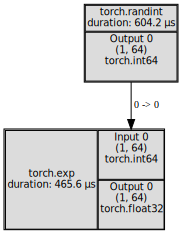

In [4]:
with trace():
    tensor = torch.randint(0, 100, (1, 64))
    tensor = torch.exp(tensor)
visualize(tensor)

## Trace torch functions and ttnn operations

2024-07-11 18:17:47.447 | DEBUG    | ttnn.tracer:visualize:442 - Dumping graph of the model to None


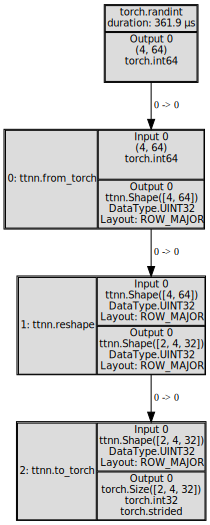

In [5]:
with trace():
    tensor = torch.randint(0, 100, (4, 64))
    tensor = ttnn.from_torch(tensor)
    tensor = ttnn.reshape(tensor, (2, 4, 32))
    tensor = ttnn.to_torch(tensor)
visualize(tensor)

## Trace torch functions, torch modules and ttnn operations

/home/ubuntu/tt-metal/python_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-07-11 18:17:48.874 | DEBUG    | ttnn.tracer:visualize:442 - Dumping graph of the model to None


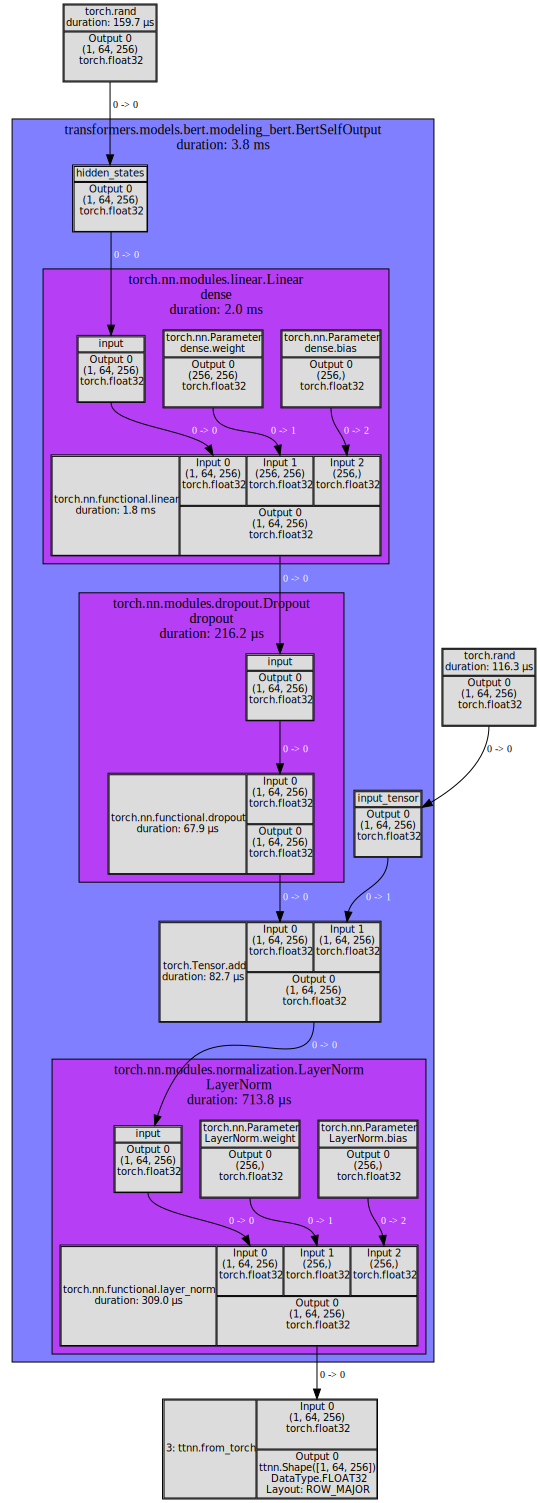

In [6]:
model_name = "google/bert_uncased_L-4_H-256_A-4"
config = transformers.BertConfig.from_pretrained(model_name)
model = transformers.models.bert.modeling_bert.BertSelfOutput(config).eval()

with trace():
    hidden_states = torch.rand((1, 64, config.hidden_size))
    input_tensor = torch.rand((1, 64, config.hidden_size))
    hidden_states = model(hidden_states, input_tensor)
    output = ttnn.from_torch(hidden_states)
visualize(output)

## Trace models written using ttnn

In [7]:
dispatch_core_type = ttnn.device.DispatchCoreType.ETH
if "grayskull" in os.environ.get("ARCH_NAME"):
    dispatch_core_type = ttnn.device.DispatchCoreType.WORKER
device = ttnn.open_device(device_id=0, l1_small_size=8192, dispatch_core_type=dispatch_core_type)

                 Device | INFO     | Opening user mode device driver

2024-07-11 18:17:48.936 | INFO     | SiliconDriver   - Detected 1 PCI device : {0}
2024-07-11 18:17:48.949 | WARNING  | SiliconDriver   - init_detect_tt_device_numanodes(): Could not determine NumaNodeSet for TT device (physical_device_id: 0 pci_bus_id: 0000:07:00.0)
2024-07-11 18:17:48.949 | WARNING  | SiliconDriver   - Could not find NumaNodeSet for TT Device (physical_device_id: 0 pci_bus_id: 0000:07:00.0)
2024-07-11 18:17:48.951 | WARNING  | SiliconDriver   - bind_area_memory_nodeset(): Unable to determine TT Device to NumaNode mapping for physical_device_id: 0. Skipping membind.
---- ttSiliconDevice::init_hugepage: bind_area_to_memory_nodeset() failed (physical_device_id: 0 ch: 0). Hugepage allocation is not on NumaNode matching TT Device. Side-Effect is decreased Device->Host perf (Issue #893).
2024-07-11 18:17:48.960 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.9.0 (Device 0)
  

In [8]:
from models.demos.bert.tt import ttnn_bert
from models.demos.bert.tt import ttnn_optimized_bert
from ttnn.model_preprocessing import preprocess_model_parameters

def ttnn_bert(bert):
    model_name = "phiyodr/bert-large-finetuned-squad2"
    
    config = transformers.BertConfig.from_pretrained(model_name)
    config.num_hidden_layers = 1
    
    batch_size = 8
    sequence_size = 384
            
    parameters = preprocess_model_parameters(
        initialize_model=lambda: transformers.BertForQuestionAnswering.from_pretrained(
            model_name, config=config
        ).eval(),
        custom_preprocessor=bert.custom_preprocessor,
        device=device,
    )

    with trace():
        input_ids = torch.randint(0, config.vocab_size, (batch_size, sequence_size)).to(torch.int32)
        torch_token_type_ids = torch.zeros((batch_size, sequence_size), dtype=torch.int32)
        torch_position_ids = torch.zeros((batch_size, sequence_size), dtype=torch.int32)
        torch_attention_mask = torch.zeros(1, sequence_size) if bert == ttnn_optimized_bert else None
        

        ttnn_bert_inputs = bert.preprocess_inputs(
            input_ids,
            torch_token_type_ids,
            torch_position_ids,
            torch_attention_mask,
            device=device,
        )
    
        output = bert.bert_for_question_answering(
            config,
            *ttnn_bert_inputs,
            parameters=parameters,
        )
        output = ttnn.from_device(output)
        
    return visualize(output)

/home/ubuntu/tt-metal/python_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-07-11 18:17:50.339 | DEBUG    | ttnn:manage_config:144 - Set ttnn.CONFIG.enable_logging to False
2024-07-11 18:17:50.340 | DEBUG    | ttnn:manage_config:144 - Set ttnn.CONFIG.enable_comparison_mode to False
2024-07-11 18:17:50.341 | WARNING  | ttnn.model_preprocessing:from_torch:555 - ttnn: model cache can be enabled by passing model_name argument to preprocess_model[_parameters] and setting env variable TTNN_CONFIG_OVERRIDES='{"enable_model_cache": true}'
2024-07-11 18:17:51.343 | DEBUG    | ttnn.model_preprocessing:from_torch:634 - Moving model weights to device
2024-07-11 18:17:51.366 | DEBUG    | ttnn.model_preprocessing:from_torch:636 - Moved model weights to device
2024-07-11

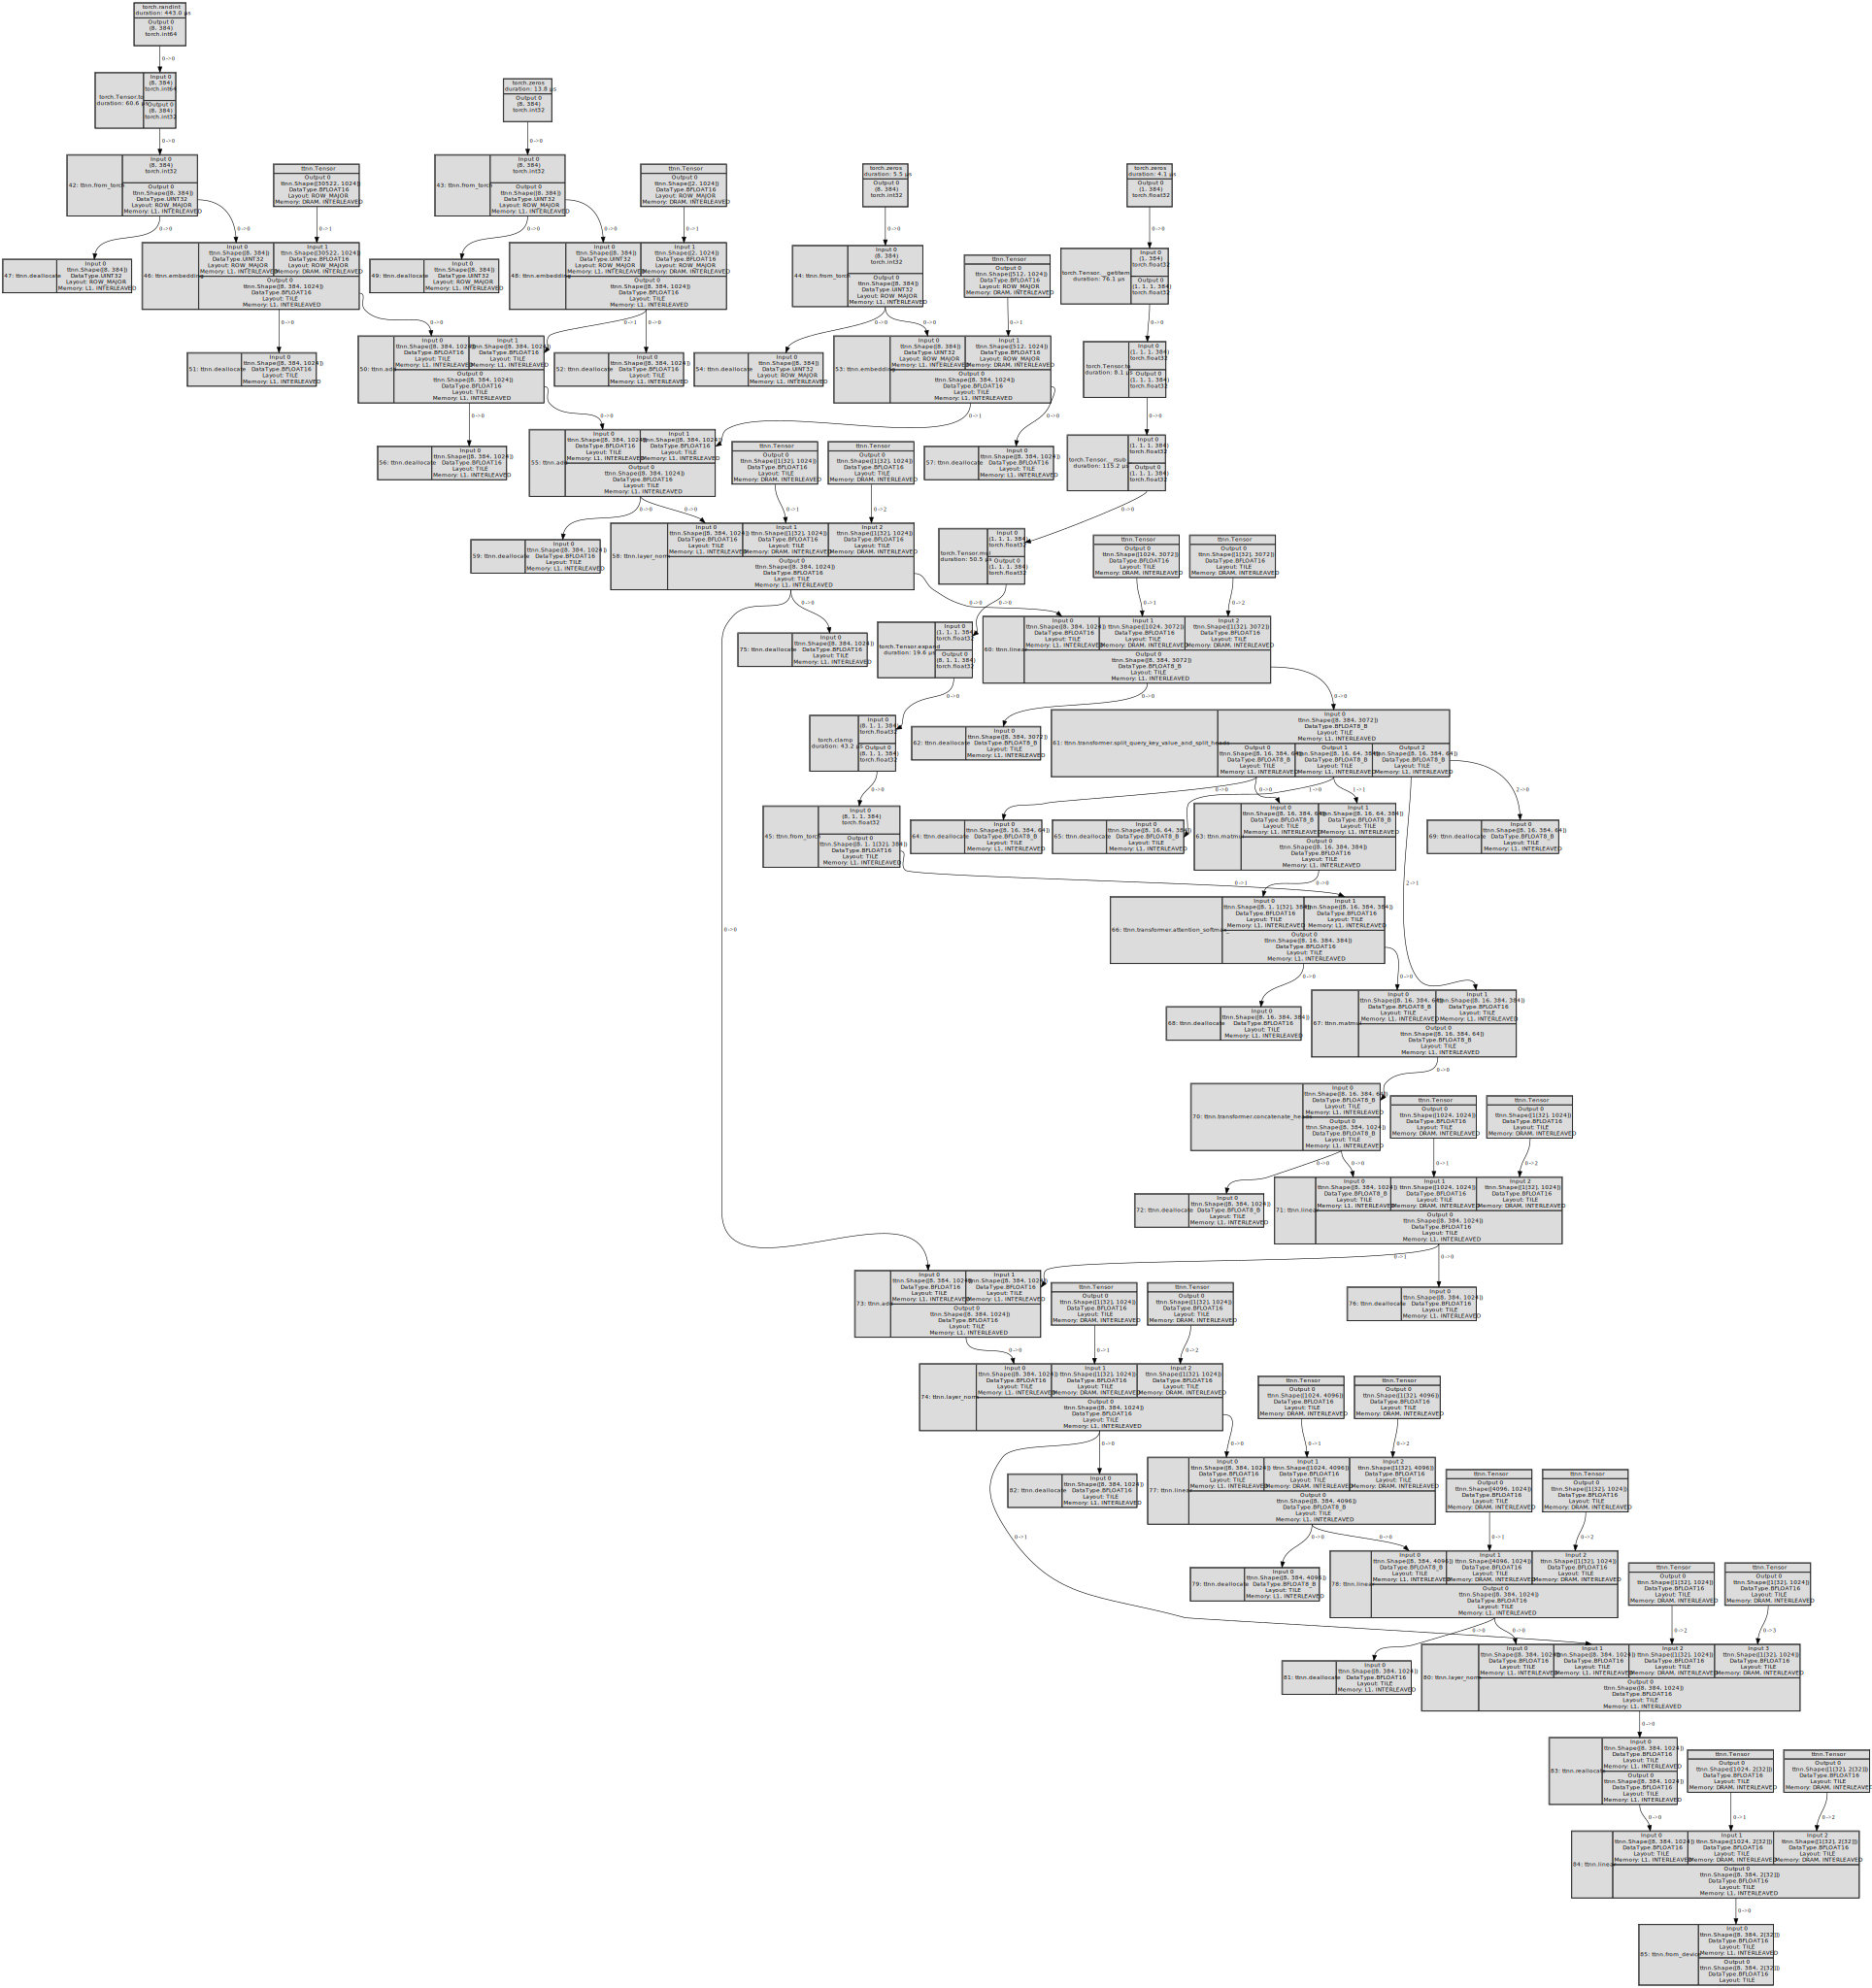

In [9]:
ttnn_bert(ttnn_optimized_bert)

In [10]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0
